### Imports

In [1]:
from data_functions import *
import copy
import os
import logging
import traceback

# sys.path.insert(1, "H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM")

import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from plot_lstm_results import plot_lstm_results
from network_models import LSTM
from train_test import train, test
from S2LDataset import S2LDataset
from print_error_report import print_error_report
from objective_functions import objective_function

# On the line below, specifiy after "from" which file the user inputs are coming from.
from input_template import (
    UserInputArgs,
    PlottingArgs,
    DataInfoArgs,
    SaveDataArgs,
    DerivedArgs,
)
from load_and_standardize import load_and_standardize
from reshape_for_time_resolution import reshape_for_time_resolution, reshape_full_series
from save_lstm import save_lstm_info, load_lstm_info
from save_lstm_results import save_lstm_results, save_lstm_test_results
from unstandardize_all_data import unstandardize_all_data

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

### Description
Create and train Bimodal LSTMS 5 samples from their bucket.  Compare to the TL MED LSTMS where each MED LSTM was fed 5 records, randomly selected.

### Functions

In [2]:
print("Cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # to avoid some rare errors.

# Check if using CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set parameters
args = UserInputArgs()
plot_args = PlottingArgs()
data_info_args = DataInfoArgs()
save_data_args = SaveDataArgs()

# args.training_mode = False

# Load original LSTM
# args.model_load_filename = 'MED2_30'
# network, std_factors = load_lstm_info(args)
# network.to(device)

Cuda available: True


#### Transfer Learning Network

Copy medium network, train with same 5 files from bimodal network.

In [3]:
print("Cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # to avoid some rare errors.

# Check if using CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set parameters
args = UserInputArgs()
plot_args = PlottingArgs()
data_info_args = DataInfoArgs()
save_data_args = SaveDataArgs()

# args.training_mode = False

# Load original LSTM
args.model_load_filename = 'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\MED LSTM\\MED2_30'
network, std_factors = load_lstm_info(args)
network.to(device)

Cuda available: True
Loading LSTM Saved in:  H:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\Experiment_ARCHIVE\MED LSTM\MED2_30 .pickle


LSTM(
  (lstm): LSTM(4, 30, num_layers=2, batch_first=True)
  (linear): Linear(in_features=30, out_features=3, bias=True)
)

In [2]:
def generateOutput(experiment, n=5, train_mode=True, save_folder='',):
    """Given an experiment and training sample size, generate and save output files"""
    print("EXPERIMENT: ", experiment)
    
    # Create list of eligible files to train on
    exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}'
    files = [f for f in os.listdir(exp_PATH + '\\LAMP_files') if f.endswith('1.mot')]

    # Establish test files list (since we're testing on all in a folder)
    test_files = [f.replace('1.mot','3.mot') for f in files]
    # test_files = files
    data_info_args.test_lamp = [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in test_files]
    data_info_args.test_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in test_files]

    # Copy the MED LSTM
    model = copy.deepcopy(network)

    # Setup GPU Support
    print("Cuda available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # to avoid some rare errors.

    # Check if using CPU or GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    # randomly select N num_files
    train_files = np.random.choice(files, size=n, replace = False)
    print("Training on: ", train_files)
    val_files = [f.replace('1.mot','2.mot') for f in train_files]
    # Shorten val_files to 20% of train_files
    val_files = np.random.choice(val_files, size=int(.2*len(val_files)), replace = False)

    # establish the lamp and sc training file paths
    data_info_args.train_lamp = [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in train_files]
    data_info_args.train_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in train_files]

    # establish the lamp and sc validation file paths
    data_info_args.val_lamp= [exp_PATH + '\\LAMP_files\\' + f.removesuffix('.mot') for f in val_files]
    data_info_args.val_sc = [exp_PATH + '\\SimpleCode_files\\' + f.replace('LAMP','SC').removesuffix('.mot') for f in val_files]

    # Setup Derived Args
    derived_args = DerivedArgs(args, data_info_args)
    derived_args.test_batch_size = int(derived_args.num_test_realizations * args.time_res / 9)
    # print("No of train realizations: ", derived_args.num_train_realizations)
    # print("No of val realizations: ", derived_args.num_val_realizations)
    # print("No of test realizations: ", derived_args.num_test_realizations)
    # print("No of realizations: ", derived_args.num_realizations)
    # print("Train batch size: ", derived_args.train_batch_size)
    # print("Val batch size: ", derived_args.val_batch_size)
    # print("Test batch size: ", derived_args.test_batch_size)

    # Load the training and validation data
    train_input, train_target, train_sc = load_and_standardize(data_info_args.train_sc, data_info_args.train_lamp, args, std_factors)
    val_input, val_target, val_sc = load_and_standardize(data_info_args.val_sc, data_info_args.val_lamp, args, std_factors)
    test_input, test_target, test_sc = load_and_standardize(data_info_args.test_sc, data_info_args.test_lamp, args, std_factors)

    # Reshape the data to take into account the time resolution
    train_input, train_target = reshape_for_time_resolution(train_input, train_target, args)
    val_input, val_target = reshape_for_time_resolution(val_input, val_target, args)
    test_input, test_target = reshape_for_time_resolution(test_input, test_target, args)

    # Create Dataset objects for each of our train/val/test sets
    train_dataset = S2LDataset(train_input, train_target)
    val_dataset = S2LDataset(val_input, val_target)
    test_dataset = S2LDataset(test_input, test_target)

    # Create a PyTorch dataloader for each train/val set. Test set isn't needed until later
    train_loader = DataLoader(train_dataset, batch_size=derived_args.train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=derived_args.val_batch_size)

    # Create testing dataloader
    test_loader = DataLoader(test_dataset, batch_size=derived_args.test_batch_size)

    # Display dataset information
    # print("\nReshaped the following data:")
    # print(f"train_input has shape	{train_input.shape}")
    # print(f"train_target has shape	{train_target.shape}")
    # print(f"val_input has shape 	{val_input.shape}")
    # print(f"val_target has shape 	{val_target.shape}")
    # print(f"test_input has shape 	{test_input.shape}")
    # print(f"test_target has shape 	{test_target.shape}")
    realization_length = train_input.shape[1] * args.time_res

    # initialize our optimizer. We'll use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    # Begin Training
    if train_mode == True:
        best_val_loss = float("inf")
        best_loss_counter = 0
        print("\n Beginning Training")
        start_time = time.time()
        for epoch in range(1, args.epochs + 1):
            train_loss = train(model, device, train_loader, optimizer, args.train_fun_hyp)
            val_loss = test(model, device, val_loader, args.val_fun_hyp)
            if val_loss < 0.95 * best_val_loss:
                best_val_loss = val_loss
                best_loss_counter = 0
                torch.save(model.state_dict(), "recently_trained_model.pt")
            else:
                best_loss_counter += 1
            if best_loss_counter > 30:
                break
            # print("Train Epoch: {:02d} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tCounter: {:02d}".format(epoch, train_loss, val_loss, best_loss_counter))
        print("Training Done\n")
        end_time = time.time()
        trainTime = end_time - start_time
        print("Training Time: ", trainTime)
        model.load_state_dict(torch.load("recently_trained_model.pt"))  # restoring the best found network based on validation data

    start_time = time.time()
    train_lstm_output = test(model,device,train_loader,args.val_fun_hyp,derived_args.num_train_realizations,args.time_res,True,)
    val_lstm_output = test(model,device,val_loader,args.val_fun_hyp,derived_args.num_val_realizations,args.time_res,True,)
    test_lstm_output = test(model,device,test_loader,args.val_fun_hyp,derived_args.num_test_realizations,args.time_res,True,)
    end_time = time.time()
    testTime = end_time - start_time
    print("Testing Time: ", testTime)
    print("\ntrain output shape", train_lstm_output.shape)
    print("val output shape  ", val_lstm_output.shape)
    print("test output shape ", test_lstm_output.shape)
    print("Time to produce output for ",derived_args.num_realizations," realizations:",(end_time - start_time),)

    # Reshape our input and targets to be same shape as output
    train_input, train_target, train_lstm_output = reshape_full_series(train_input, train_target, train_lstm_output, args)
    val_input, val_target, val_lstm_output = reshape_full_series(val_input, val_target, val_lstm_output, args)
    test_input, test_target, test_lstm_output = reshape_full_series(test_input, test_target, test_lstm_output, args)

    # Unstandardize
    train_target, train_lstm_output = unstandardize_all_data(train_target, train_lstm_output, std_factors, args)
    val_target, val_lstm_output = unstandardize_all_data(val_target, val_lstm_output, std_factors, args)
    test_target, test_lstm_output = unstandardize_all_data(test_target, test_lstm_output, std_factors, args)

    # Print error report
    print("\nLSTM Error Results:")
    print_error_report(train_lstm_output,val_lstm_output,test_lstm_output,train_target,val_target,test_target,args,)
    
    # Save the output
    save_data_args.test = list(range(0,len(data_info_args.test_sc)))
    save_data_args.output_path = exp_PATH + f'\\{save_folder}\\'
    print("Saving output to ",save_data_args.output_path)
    save_lstm_results(train_lstm_output,val_lstm_output,test_lstm_output,save_data_args,data_info_args,args,std_factors,)
    print('')

In [5]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
do = []
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            generateOutput(exp,n=5,train_mode=True,save_folder='output_files_MED2_30_5_rand')
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            continue

EXPERIMENT:  aavs
Cuda available: True
Training on:  ['LAMP_h7.5_p15_a135_hh3_pp20_aa150_s8-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp20_aa15_s4-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp20_aa60_s14-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp20_aa135_s0-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp20_aa255_s8-0000001.mot']
full series simple (input) shape  (5, 17990, 4)
full series lamp (target) shape  (5, 17990, 3)
full series simple (input) shape  (1, 17990, 4)
full series lamp (target) shape  (1, 17990, 3)
full series simple (input) shape  (216, 17990, 4)
full series lamp (target) shape  (216, 17990, 3)

 Beginning Training
Training Done

Training Time:  68.89683818817139
Testing Time:  1.5573418140411377

train output shape (45, 1998, 3)
val output shape   (9, 1998, 3)
test output shape  (1944, 1998, 3)
Time to produce output for  222  realizations: 1.5573418140411377

LSTM Error Results:
--------------------------------------------
Training Data Errors:
MSE:                  tensor(30.1373, d

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_37756\2798844547.py", line 6, in <module>
    generateOutput(exp,n=5,train_mode=True,save_folder='output_files_MED2_30_5_rand')
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_37756\3111903558.py", line 57, in generateOutput
    test_input, test_target, test_sc = load_and_standardize(data_info_args.test_sc, data_info_args.test_lamp, args, std_factors)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\load_and_standardize.py", line 48, in load_and_standardize
    lstm_inputs, target_outputs = load_fullseries(
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\load_and_standardize.py", line 38, in load_fullseries
    np.concatenate((simple_vbm_data, simple_motion_data, wave_data), axis=1)
  File "<__array_function__ internals>", line 180, in concatenate
ValueError: all the input array dimensions for the conc

ERROR in  hvp
EXPERIMENT:  hvpp
Cuda available: True
Training on:  ['LAMP_h7_p15_a135_hh3_pp19_aa270_s8-0000001.mot'
 'LAMP_h5.5_p15_a135_hh3_pp17_aa270_s8-0000001.mot'
 'LAMP_h7_p15_a135_hh3_pp22_aa270_s8-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp23_aa270_s8-0000001.mot'
 'LAMP_h9_p15_a135_hh3_pp17_aa270_s8-0000001.mot']
full series simple (input) shape  (5, 17990, 4)
full series lamp (target) shape  (5, 17990, 3)
full series simple (input) shape  (1, 17990, 4)
full series lamp (target) shape  (1, 17990, 3)
full series simple (input) shape  (81, 17990, 4)
full series lamp (target) shape  (81, 17990, 3)

 Beginning Training
Training Done

Training Time:  169.12666130065918
Testing Time:  1.7134759426116943

train output shape (45, 1998, 3)
val output shape   (9, 1998, 3)
test output shape  (729, 1998, 3)
Time to produce output for  87  realizations: 1.7134759426116943

LSTM Error Results:
--------------------------------------------
Training Data Errors:
MSE:                  tensor(6.24

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_37756\2798844547.py", line 6, in <module>
    generateOutput(exp,n=5,train_mode=True,save_folder='output_files_MED2_30_5_rand')
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_37756\3111903558.py", line 29, in generateOutput
    train_files = np.random.choice(files, size=n, replace = False)
  File "mtrand.pyx", line 915, in numpy.random.mtrand.RandomState.choice
ValueError: 'a' cannot be empty unless no samples are taken




EXPERIMENT:  pva
Cuda available: True
ERROR in  pva
EXPERIMENT:  pvaa
Cuda available: True
Training on:  ['LAMP_h7.5_p11_a135_hh3_pp20_aa330_s8-0000001.mot'
 'LAMP_h7.5_p11_a135_hh3_pp20_aa30_s8-0000001.mot'
 'LAMP_h7.5_p11_a135_hh3_pp20_aa135_s8-0000001.mot'
 'LAMP_h7.5_p15_a135_hh3_pp20_aa90_s8-0000001.mot'
 'LAMP_h7.5_p12_a135_hh3_pp20_aa90_s8-0000001.mot']
full series simple (input) shape  (5, 17990, 4)
full series lamp (target) shape  (5, 17990, 3)
full series simple (input) shape  (1, 17990, 4)
full series lamp (target) shape  (1, 17990, 3)
full series simple (input) shape  (216, 17990, 4)
full series lamp (target) shape  (216, 17990, 3)

 Beginning Training
Training Done

Training Time:  40.08734130859375
Testing Time:  1.2530791759490967

train output shape (45, 1998, 3)
val output shape   (9, 1998, 3)
test output shape  (1944, 1998, 3)
Time to produce output for  222  realizations: 1.2530791759490967

LSTM Error Results:
--------------------------------------------
Training D

In [6]:
# def LSTMvLAMP_df(experiment="",LSTM_files='', realization=''):
    
#     from pathlib import Path
#     import pandas as pd

#     """Makes a dataframe comparing LSTM and LAMP outputs
#         experiment = folder name of the experiment"""

#     # Establish paths
#     exp_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\{experiment}\\'

#     # network options
#     # nwOptions = ('original', 'new')
    
#     # No experiment or network given
#     if experiment == "" or LSTM_files == '':
#         return "INVALID EXPERIMENT OR NETWORK"

#     # Parse out the variables observed
#     v1 = experiment.partition("v")[0]  # Pulls first variable by taking string before "_", spliting at the "v"
#     v2 = experiment.partition("v")[2]  # 2nd variable

#     # LAMP path
#     LAMP_path = exp_PATH + "\\LAMP_files\\"

#     # LSTM data
#     exp_PATH += LSTM_files + '\\'

#     # Set experiment path
#     # if network.lower() == "original":
#     #     exp_PATH += "\\output_files_MED\\"
#     # elif network.lower() == "new":
#     #     exp_PATH += "\\output_files_MED2_30_50\\"

#     # Make the dataframe for LSTM
#     df_LSTM = pd.DataFrame(
#         columns=[v1, v2, "Zcg", "Roll", "Pitch"]
#     )  # Create cols for the altered variables in experiement and heave, roll, pitch

#     # step through every LSTM file in the experiement to get the SSA, and add to dataframe
#     for path in Path(exp_PATH).glob(f"*{realization}.txt"):
#         # Get the SSA's
#         SSA = get_LSTM_SSA(path)
#         # Get the variable combo for the file
#         trial = path.name.lstrip("lstm_output_for_SC_")
#         idx = trial.partition(v1)[2]
#         t1 = idx.partition("_")[0]
#         if v2 == "s":
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("-")[0]
#         else:
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("_")[0]

#         SSA[v1] = float(t1)
#         SSA[v2] = float(t2)

#         df_LSTM.loc[len(df_LSTM)] = SSA

#     df_LSTM = df_LSTM.sort_values(by=[v1, v2])

#     # Make the dataframe for LAMP
#     df_LAMP = pd.DataFrame(columns=[v1, v2, "Zcg", "Roll", "Pitch"])

#     # step through every LAMP file in the experiement to get the SSA, and add to dataframe
#     for path in Path(LAMP_path).glob(f"*{realization}.mot"):
#         # Get the SSA's
#         SSA = get_LAMP_SSA(path)
#         # Get the variable combo for the file
#         trial = path.name.lstrip("LAMP_")
#         idx = trial.partition(v1)[2]
#         t1 = idx.partition("_")[0]
#         if v2 == "s":
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("-")[0]
#         else:
#             idx = trial.partition(v2)[2]
#             t2 = idx.partition("_")[0]

#         SSA[v1] = float(t1)
#         SSA[v2] = float(t2)

#         df_LAMP.loc[len(df_LAMP)] = SSA

#     df_LAMP = df_LAMP.sort_values(by=[v1, v2])

#     # Establish new, final DF for heatmap
#     df_final = pd.DataFrame(columns=[v1, v2, "Zcg Error", "Roll Error", "Pitch Error"])
#     df_final[v1] = df_LSTM[v1]
#     df_final[v2] = df_LSTM[v2]

#     # find the absolute difference between each in the series
#     df_final["Zcg Error"] = np.abs(df_LSTM["Zcg"] - df_LAMP["Zcg"])
#     df_final["Roll Error"] = np.abs(df_LSTM["Roll"] - df_LAMP["Roll"])
#     df_final["Pitch Error"] = np.abs(df_LSTM["Pitch"] - df_LAMP["Pitch"])

#     return df_final, v1, v2

In [7]:
# def makeHeatmap(top_network,bottom_network, experiment, parameter, realization, save_file):
#     import seaborn as sns
#     """
#     Creates a heatmap of SSA error between unimodal LSTM and same LSTM trained with bimodal seas. Given a df of the form:
#     v1      v2    Zcg Error       Roll Error    Pitch Error
#     experiment = case file
#     network = network trained on
#     parameter = parameter we want to see
#     """

#     # Renaming Based on Experiment ID
#     EXP_ID = {'aa': 'Secondary Heading', 'a': 'Primary Heading', 'hh': 'Secondary Height', 'h': 'Primary Height', 'pp': 'Secondary Period', 'p': 'Primary Period', 's': 'Ship Speed'}
#     EXP_ID_units = {'aa': r'$Secondary Heading (^{\circ})$', 'a': r'$Primary Heading (^{\circ})$', 'hh': 'Secondary Height (m)', 'h': 'Primary Height (m)', 'pp': 'Secondary Period (sec)', 'p': 'Primary Period (sec)', 's': 'Ship Speed (knots)'}
#     plot_ID = experiment.split('v')

#     # Set save path for the figure
#     SAVE_PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Transfer Learning Figures\\{save_file}'

#     # Set units for color bar
#     if parameter == "Zcg Error":
#         units = "meters"
#     else:
#         units = r"$^{\circ}$"

#     # Set the fig and ax
#     fig, (axo, axn, axd) = plt.subplots(3, figsize=(16, 16), sharey=True)
#     # cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
#     cbar_ax = fig.add_axes([0.91, 0.425, 0.03, 0.4])
#     rbar_ax = fig.add_axes([0.91, 0.125, 0.03, 0.2])
#     fig.suptitle(f"{EXP_ID[plot_ID[0]]} vs {EXP_ID[plot_ID[1]]} Absolute SSA {parameter}", fontsize=18)
#     fig.supxlabel(f'{EXP_ID_units[plot_ID[0]]}')
#     fig.supylabel(f'{EXP_ID_units[plot_ID[1]]}')
#     colormap= sns.diverging_palette(0,145,sep=15,as_cmap=True)
#     cbar_ax.set_ylabel(units)

#     # get the Original dataset
#     dfo, v1, v2 = LSTMvLAMP_df(experiment, 'output_files_'+top_network, realization)
#     resulto = dfo.pivot(index=v2, columns=v1, values=parameter)

#     # Set colorbar max value
#     vmax = resulto.max().max()

#     # get the new dataset
#     dfn, v1, v2 = LSTMvLAMP_df(experiment, 'output_files_'+bottom_network, realization)
#     resultn = dfn.pivot(index=v2, columns=v1, values=parameter)

#     # Set colorbar max value to that of new if it's more than med
#     if resultn.max().max() > vmax:
#         vmax = resultn.max().max()

#     # Plot original dataset
#     g1 = sns.heatmap(
#         resulto,cmap="Blues",ax=axo, cbar=True,vmax=vmax,cbar_ax=cbar_ax, # annot = True, fmt = ".2f"
#     )
#     g1.invert_yaxis()
#     if 'BiMod' in top_network:
#         g1.set_title("Bimodal Training, N=" + top_network[-1])
#     else:
#         g1.set_title("Transfer Learning, N=" + top_network[-1])
#     g1.set_xlabel('')
#     g1.set_ylabel('')

#     # get the new dataset
#     g2 = sns.heatmap(
#         resultn, cmap="Blues", ax=axn, cbar_kws={"label": units}, cbar=True, vmax=vmax, cbar_ax=cbar_ax, # annot = True, fmt = ".2f"
#     )
#     g2.invert_yaxis()
#     if 'BiMod' in bottom_network:
#         g2.set_title("Bimodal Training, N=" + bottom_network[-1])
#     else:
#         g2.set_title("Transfer Learning, N=" + bottom_network[-1])
#     g2.set_xlabel('')
#     g2.set_ylabel('')

#     # Plot a heatmap comparing the difference between the two.  Bigger is better b/c delta_orig - delta_new means new performed much better
#     dfc = dfn.copy()
#     cols =  dfo.columns.difference([v1,v2])
#     dfc[cols] = dfo[cols] - dfn[cols]
#     resultc = dfc.pivot(index=v2, columns=v1, values=parameter)

#     # set colorbar max and min values
#     vmax = resultc.max().max()
#     vmin = resultc.min().min()

#     g3 = sns.heatmap(
#         resultc, cmap=colormap, ax=axd, cbar_kws={'label': units, 'ticks':[vmin,0,vmax], 'format': '%.2f'}, cbar=True, center=0, cbar_ax=rbar_ax, # annot = True, fmt = ".2f"
#     )
#     g3.invert_yaxis()
#     g3.set_title("Delta")
#     g3.set_xlabel('')
#     g3.set_ylabel('')

#     # Save the figure
#     plt.savefig(f"{SAVE_PATH}\\{experiment}_{save_file}_{parameter}_{realization}.png")


### Testing HeatMaps

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_37756\1412017913.py", line 6, in <module>
    makeHeatmap(top_network='BiMod2_30_5',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod5_rand')
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\data_functions.py", line 203, in makeHeatmap
    resulto = dfo.pivot(index=v2, columns=v1, values=parameter)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\frame.py", line 7885, in pivot
    return pivot(self, index=index, columns=columns, values=values)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\reshape\pivot.py", line 520, in pivot
    return indexed.unstack(columns_listlike)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thes

ERROR in  hvp


ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_37756\1412017913.py", line 6, in <module>
    makeHeatmap(top_network='BiMod2_30_5',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod5_rand')
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\data_functions.py", line 203, in makeHeatmap
    resulto = dfo.pivot(index=v2, columns=v1, values=parameter)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\frame.py", line 7885, in pivot
    return pivot(self, index=index, columns=columns, values=values)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\reshape\pivot.py", line 520, in pivot
    return indexed.unstack(columns_listlike)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thes

ERROR in  pva


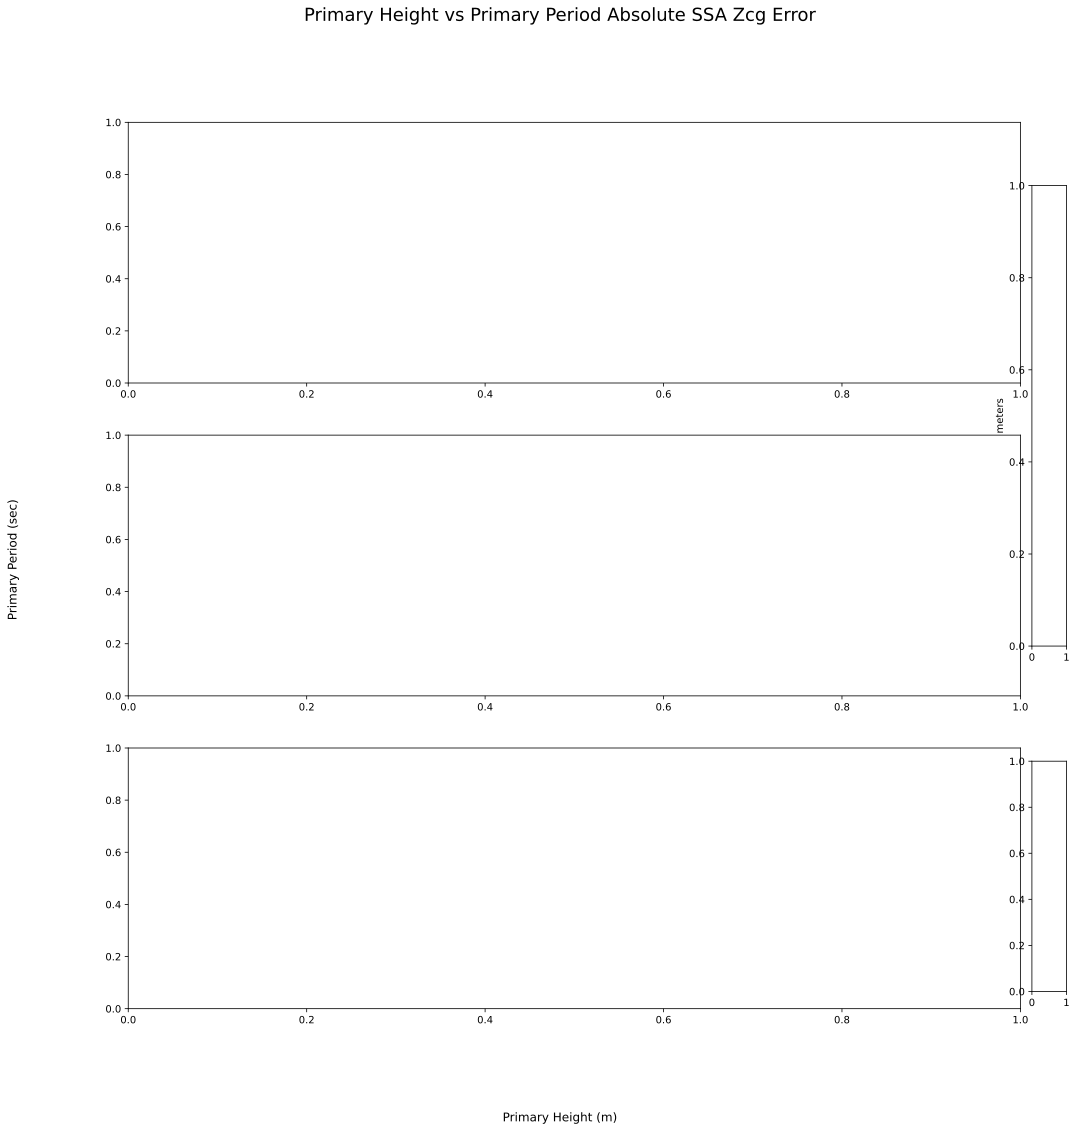

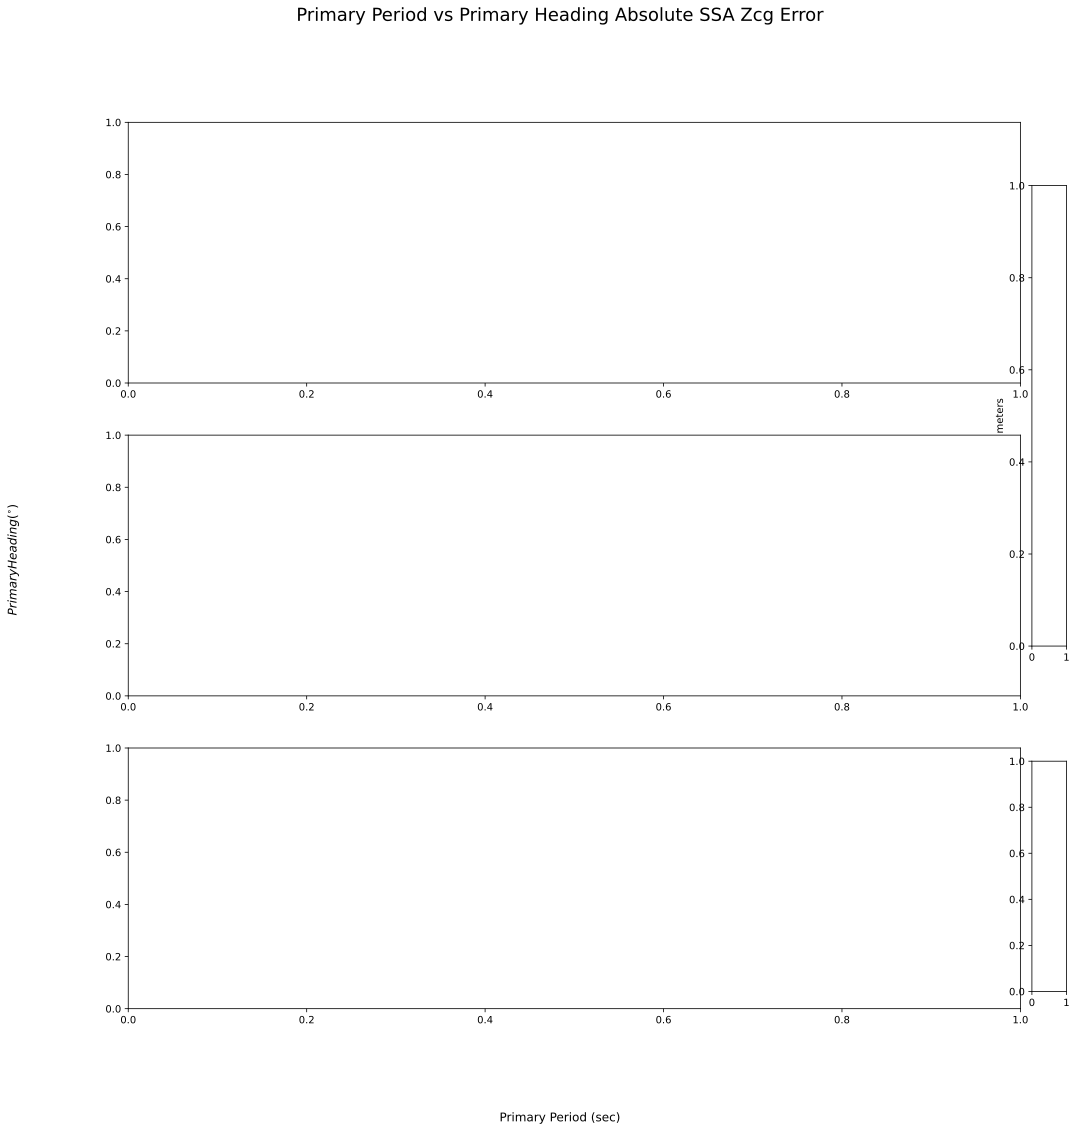

In [8]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            makeHeatmap(top_network='BiMod2_30_5',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod5_rand')
            plt.close()
            makeHeatmap(top_network='BiMod2_30_5',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Roll Error", realization='3', save_file='TL5_vs_BiMod5_rand')
            plt.close()
            makeHeatmap(top_network='BiMod2_30_5',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Pitch Error", realization='3', save_file='TL5_vs_BiMod5_rand')
            plt.close()
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            continue

ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_37756\837978200.py", line 6, in <module>
    makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod50_rand')
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\data_functions.py", line 203, in makeHeatmap
    resulto = dfo.pivot(index=v2, columns=v1, values=parameter)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\frame.py", line 7885, in pivot
    return pivot(self, index=index, columns=columns, values=values)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\reshape\pivot.py", line 520, in pivot
    return indexed.unstack(columns_listlike)
  File "h:\OneDrive - Massachusetts Institute of Technology\The

ERROR in  hvp


ERROR:root:Traceback (most recent call last):
  File "C:\Users\jarod\AppData\Local\Temp\ipykernel_37756\837978200.py", line 6, in <module>
    makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod50_rand')
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\data_functions.py", line 203, in makeHeatmap
    resulto = dfo.pivot(index=v2, columns=v1, values=parameter)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\frame.py", line 7885, in pivot
    return pivot(self, index=index, columns=columns, values=values)
  File "h:\OneDrive - Massachusetts Institute of Technology\Thesis\SimpleCode_to_LAMP_LSTM\venv\lib\site-packages\pandas\core\reshape\pivot.py", line 520, in pivot
    return indexed.unstack(columns_listlike)
  File "h:\OneDrive - Massachusetts Institute of Technology\The

ERROR in  pva


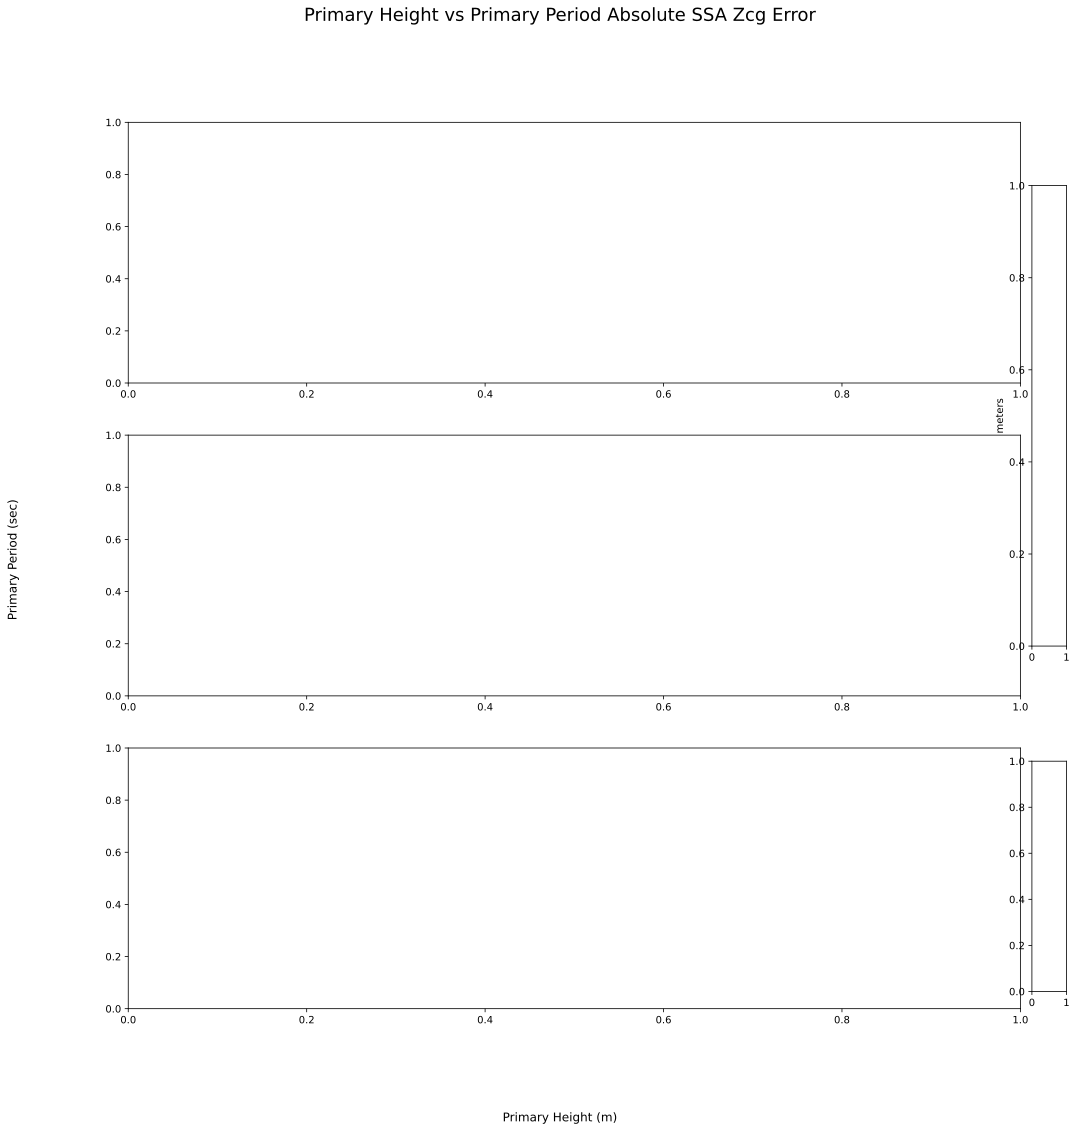

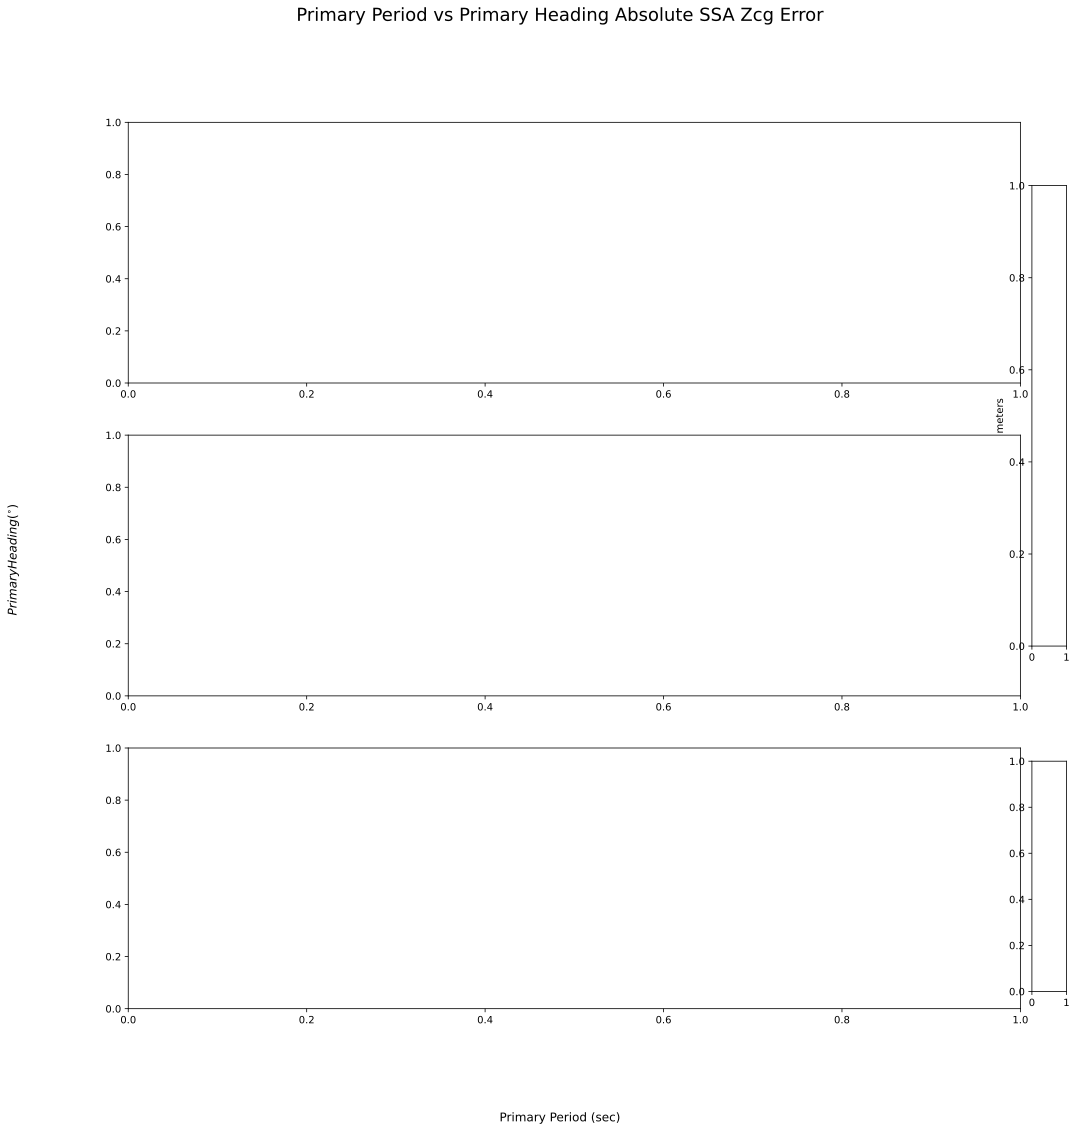

In [9]:
PATH = f'H:\\OneDrive - Massachusetts Institute of Technology\\Thesis\\SimpleCode_to_LAMP_LSTM\\Experiment_ARCHIVE\\Bimodal Test Sets\\'
ignore = ['Cases_files', '.ipynb_checkpoints','SecAngleOnly_test','__pycache__']
for exp in os.listdir(PATH):
    if os.path.isdir(PATH + exp) and exp not in ignore:
        try:
            makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod50_rand')
            plt.close()
            makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Roll Error", realization='3', save_file='TL5_vs_BiMod50_rand')
            plt.close()
            makeHeatmap(top_network='BiMod2_30_50',bottom_network='MED2_30_5_rand',experiment=exp, parameter="Pitch Error", realization='3', save_file='TL5_vs_BiMod50_rand')
            plt.close()
        except Exception as e:
            logging.error(traceback.format_exc())
            print('ERROR in ', exp)
            continue

try:
    makeHeatmap(top_network='BiMod2_30_5',bottom_network='MED2_30_5',experiment='aavs', parameter="Zcg Error", realization='3', save_file='TL5_vs_BiMod5')
    # makeHeatmap('aavs', "Roll Error", '3')
    # makeHeatmap('aavs', "Pitch Error", '3')
except Exception as e:
    logging.error(traceback.format_exc())